# Contact quadratic harmonic oscillator
The contact quadratic harmonic oscillator presents the following Hamiltonian description:
$$ H = \frac{p^2}{2} + \frac{q^2}{2} + \gamma \frac{s^2}{2} - C, $$
where $\gamma$ and $C$ are two positive parameters. It presents also an Lagrangian description:
$$ L = \frac{\dot{q}^2}{2} - \frac{q^2}{2} - \gamma \frac{s^2}{2} + C. $$

In [1]:
import numpy as np
import scipy.optimize as so
import matplotlib.pylab as plt
import time

plt.style.use("fast")  # alt: 'seaborn-white'

# plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
from integrators.common import rk4
import integrators.contact as ci
from integrators.xhformulas import *

In [3]:
class Osc:
    def __init__(self, γ, C=0):
        self.γ = γ
        self.C = C

    def V(self, x, t):
        return 0.5 * x ** 2 - self.C

    def Vq(self, x, t):
        return x

    def f(self, t):
        return self.γ

    def F(self, z, t):
        return 0.5 * self.f(t) * z ** 2

    def Fz(self, z, t):
        return self.f(t) * z

# Contact integrators

The integrator for the quadratic oscillator case is implicit. You can see the implementations below.

In [4]:
def quadratic_v(init, tspan, γ, C=0):
    p0, q0, s0 = init
    osc = Osc(γ, C)
    return ci.integrate(ci.variational_step, osc, tspan, p0, q0, s0)


def quadratic_h(init, tspan, γ, C=0):
    p0, q0, s0 = init
    osc = Osc(γ, C)
    return ci.integrate(ci.step1q, osc, tspan, p0, q0, s0)

# Euler-type integrators

In [5]:
osc = lambda p, x, z, t, γ: -x - γ * p * z


def rk4s(init, tspan, γ, h, acc, C=0):
    lag = lambda p, q, z: p ** 2 / 2.0 - q ** 2 / 2.0 + C - γ * z ** 2 / 2.0

    def derivs(x, t):
        dp = acc(x[0], x[1], x[2], 0, γ)
        dq = x[0]
        dz = lag(x[0], x[1], x[2])
        return (dp, dq, dz)

    return rk4(derivs, init, tspan)


# explicit midpoint
def midpoint(init, tspan, γ, h, acc, C=0):
    steps = len(tspan)
    hsq = np.math.pow(h, 2)
    lacc = lambda p, q, z: acc(p, q, z, 0, γ)
    lag = lambda p, q, z: p ** 2 / 2.0 - q ** 2 / 2.0 + C - γ * z ** 2 / 2.0

    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps - 1):
        p, x, z = sol[i]
        half = h / 2.0
        pmid = p + half * lacc(p, x, z)
        xmid = x + half * p
        zmid = z + half * lag(p, x, z)

        pnew = p + h * lacc(pmid, xmid, zmid)
        xnew = x + h * pmid
        znew = z + h * lag(pmid, xmid, zmid)
        sol[i + 1] = np.array([pnew, xnew, znew])
    return sol

# Symplectic integrators (hand adapted)

In this case symplectic integrators cannot be applied as-is. One should introduce a dummy variable to make the system even-dimensional again. Below we add some hand crafted implementations for the comparisons.

_Note that the comparison will not be very meaningful in this case, so we decided to omit it from the paper._

In [6]:
def leapfrog(init, tspan, γ, h, acc):
    steps = len(tspan)
    hsq = np.math.pow(h, 2)
    lacc = lambda p, q, z: acc(p, q, z, 0, γ)

    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps - 1):
        p, x, z = sol[i]
        xnew = x + h * p + hsq / 2.0 * lacc(p, x, z)
        (znew,) = so.fsolve(
            lambda znew: z
            - znew
            + h
            * (
                0.5 * ((xnew - x) / h) ** 2
                - 0.25 * (x ** 2 + xnew ** 2)
                - 0.25 * γ * (z ** 2 + znew ** 2)
            ),
            z,
        )
        pnew = p + h * (lacc(p, x, z) + lacc(p, xnew, znew)) / 2.0
        sol[i + 1] = np.array([pnew, xnew, znew])

    return sol

In [7]:
def relerr(ref, sol, shift=10.0):
    """
    Regularized relative error between the reference solution
    and the approximation: abs((shift+sol)/(shift+ref)-1.0)
    As the solutions that we are going to discuss have often a very
    small magnitude, we shift the solutions from 0 to avoid division
    by zero errors. We chose this function to emphasize the relative
    size of the error compared to the solution.
    """
    return np.abs((shift + sol) / (shift + ref) - 1.0) / 3.0

In [8]:
def cmp_plot(init, tspan, γ, h, delta, acc=osc, save=False, full=False):

    t0, tf = tspan
    ts = np.arange(t0, tf, h)
    tsfine = np.arange(t0, tf, h / delta)

    r = rk4s(init, tsfine, γ, h / delta, acc)

    s1pq, s1s, _ = quadratic_v(init, ts, γ)
    s2pq, s2s, _ = quadratic_h(init, ts, γ)
    s4 = midpoint(init, ts, γ, h, acc)

    if full:
        s3 = ci.vaariational_quadratic_implicit(init, ts, γ, h)
        s5 = leapfrog(init, ts, γ, h, acc)

    # This may be needed when the time step or the delta are not even
    rtrim = r[::delta, 1]
    rtrim = rtrim[: len(ts)]
    r2trim = r[::delta, 2]
    r2trim = r2trim[: len(ts)]

    plt.figure(figsize=(20, 20))

    plt.subplot(411)
    plt.title(
        "Solution for $\\tau={}$, $\\gamma={}$, $(p_0,q_0,z_0)={}$".format(
            h, γ, tuple(init)
        )
    )
    plt.plot(ts, s1pq[:, 1], label="CVI (1st)", linestyle="--", linewidth=0.5)
    if full:
        plt.plot(ts, s3[:, 1], label="CVI (2nd)", linestyle="-.", linewidth=0.5)
    plt.plot(ts, s2pq[:, 1], label="CHI (2nd)", linestyle="--", linewidth=0.5)
    plt.plot(
        ts, s4[:, 1], label="Explicit midpoint (2nd)", linestyle=":", linewidth=0.8
    )
    if full:
        plt.plot(ts, s5[:, 1], label="Leapfrog", linestyle=":", linewidth=0.5)
    plt.plot(
        tsfine[: len(r[:, 1])], r[:, 1], label="Reference", linestyle="-", linewidth=0.5
    )
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("$q$")

    plt.subplot(412)
    # plt.title("Momentum")
    plt.plot(ts, s1pq[:, 0], label="CVI (1st)", linestyle="--", linewidth=0.5)
    if full:
        plt.plot(ts, s3[:, 0], label="CVI (2nd)", linestyle="-.", linewidth=0.5)
    plt.plot(ts, s2pq[:, 0], label="CHI (2nd)", linestyle="--", linewidth=0.5)
    plt.plot(
        ts, s4[:, 0], label="Explicit midpoint (2nd)", linestyle=":", linewidth=0.8
    )
    if full:
        plt.plot(ts, s5[:, 0], label="Leapfrog", linestyle=":", linewidth=0.5)
    plt.plot(
        tsfine[: len(r[:, 0])], r[:, 0], label="Reference", linestyle="-", linewidth=0.5
    )
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("$p$")

    plt.subplot(413)
    # plt.title("z-component")
    plt.plot(ts, s1s, label="CVI (1st)", linestyle="--", linewidth=0.5)
    if full:
        plt.plot(ts, s3[:, 2], label="CVI (2nd)", linestyle="-.", linewidth=0.5)
    plt.plot(ts, s2s, label="CHI (2nd)", linestyle="-", linewidth=0.5)
    plt.plot(
        ts, s4[:, 2], label="Explicit midpoint (2nd)", linestyle=":", linewidth=0.8
    )
    if full:
        plt.plot(ts, s5[:, 2], label="Leapfrog", linestyle=":", linewidth=0.5)
    plt.plot(
        tsfine[: len(r[:, 2])], r[:, 2], label="Reference", linestyle="-", linewidth=0.5
    )
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("$s$")

    plt.subplot(414)
    plt.title("Error")
    plt.plot(
        ts,
        relerr(rtrim, s1pq[:, 1]) + relerr(rtrim, s1pq[:, 0]) + relerr(r2trim, s1s),
        label="CVI (1st)",
        linestyle="--",
        linewidth=0.5,
    )
    if full:
        plt.plot(
            ts,
            relerr(rtrim, s3[:, 1])
            + relerr(rtrim, s3[:, 0])
            + relerr(r2trim, s3[:, 2]),
            label="CVI (2nd)",
            linestyle="-.",
            linewidth=0.5,
        )
    plt.plot(
        ts,
        relerr(rtrim, s2pq[:, 1]) + relerr(rtrim, s2pq[:, 0]) + relerr(r2trim, s2s),
        label="CHI (2nd)",
        linestyle="-",
        linewidth=0.5,
    )
    plt.plot(
        ts,
        relerr(rtrim, s4[:, 1]) + relerr(rtrim, s4[:, 0]) + relerr(r2trim, s4[:, 2]),
        label="Explicit midpoint (2nd)",
        linestyle=":",
        linewidth=0.8,
    )
    if full:
        plt.plot(
            ts,
            relerr(rtrim, s5[:, 1])
            + relerr(rtrim, s5[:, 0])
            + relerr(r2trim, s5[:, 2]),
            label="Leapfrog",
            linestyle=":",
            linewidth=0.5,
        )
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("Relative error")

    if save:
        name = "images/quadratic{}.pdf".format(a)
        plt.savefig(name, format="pdf", transparent=True, bbox_inches="tight")

    plt.show()

In [9]:
def times(init, tspan, γ, h, acc=osc,rep=5):
    t0, tf = tspan
    ts = np.arange(t0, tf, h)
    delta=np.zeros((rep,5))
    for i in range(rep):
        start=time.time()
        _ = rk4s(init, ts, γ, h, acc)
        split1=time.time()
        _, _, _ = quadratic_v(init, ts, γ)
        split2=time.time()
        _, _, _ = quadratic_h(init, ts, γ)
        split3=time.time()
        _ = midpoint(init, ts, γ, h, acc)
        split4=time.time()
        _ = leapfrog(init, ts, γ, h, acc)
        endtime=time.time()
        #
        delta[i,:]=np.array([split3-split2,split2-split1,split1-start,split4-split3,endtime-split4])

    times= np.mean(delta, axis=0)
    std1 = np.std(delta, axis=0)
    print("           Time of Executions in seconds ")
    print("dt = ", h)
    print("-----------------------------------------------------------------------")
    print("CHI (2nd):          ", times[0], "+/-", std1[0])
    print("CVI (2nd):          ", times[1], "+/-", std1[1])
    print("Runge–Kutta (4th):  ", times[2], "+/-", std1[2])
    print("Midpoint:           ", times[3], "+/-", std1[3])
    print("Leapfrog (adapted): ", times[4], "+/-", std1[4])

# Examples of comparisons between contact Hamiltonian, contact variational and different references.

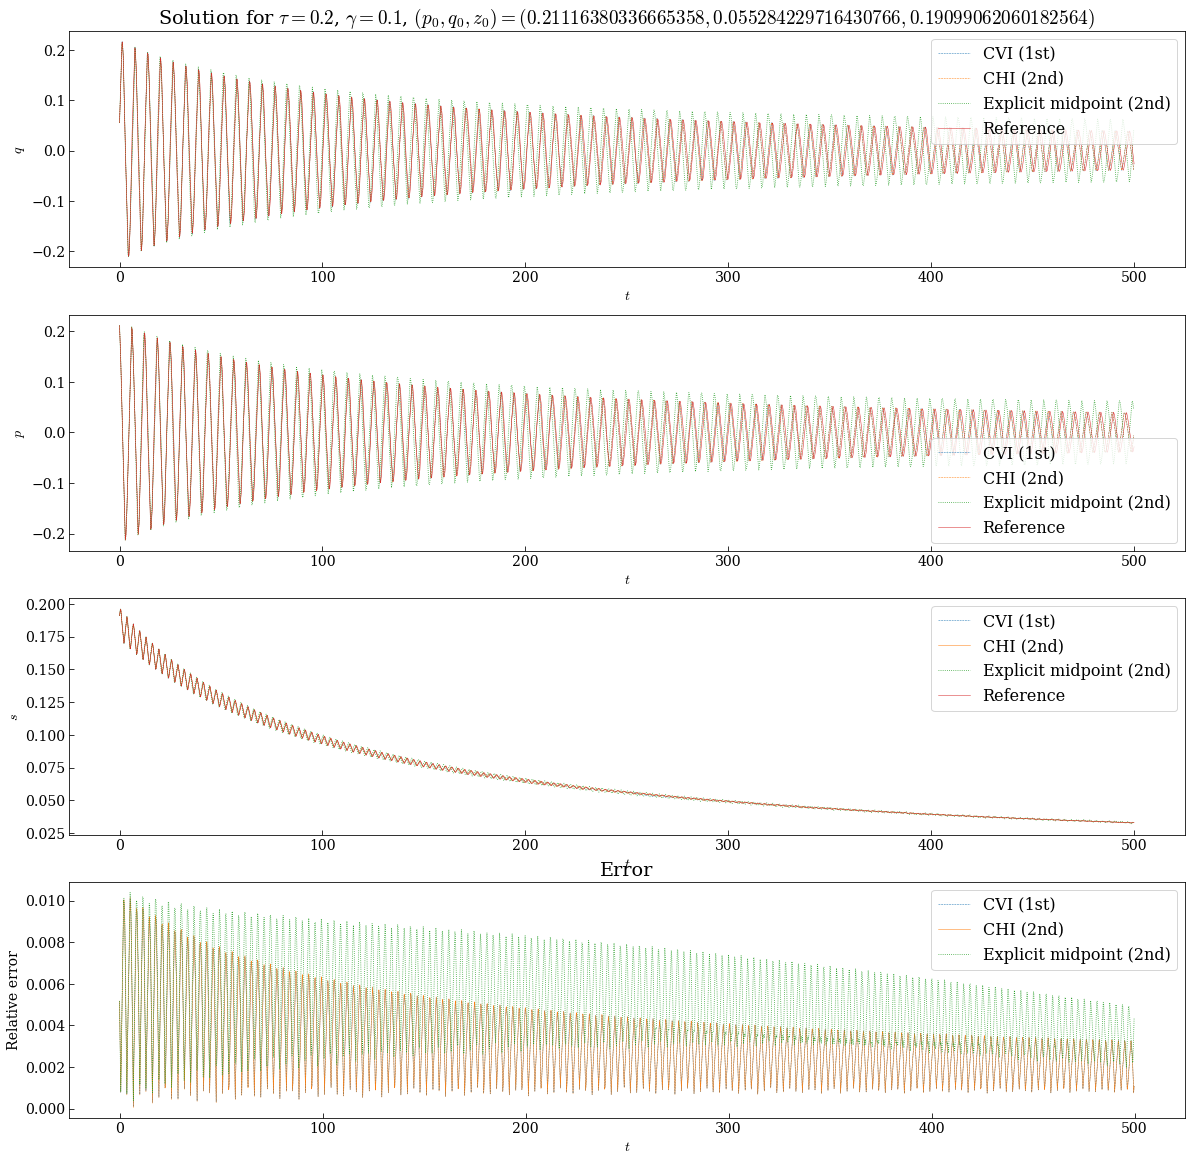

In [10]:
# init = (.5, -.7, -.2)
init = 0.5 * np.random.rand(3)
tspan = (0.0, 500.0)
a = 0.1
h = 0.2
delta = 10

cmp_plot(init, tspan, a, h, delta)

# quadratic(init, np.arange(0.0, 50.0, 0.3), a, 0.2)

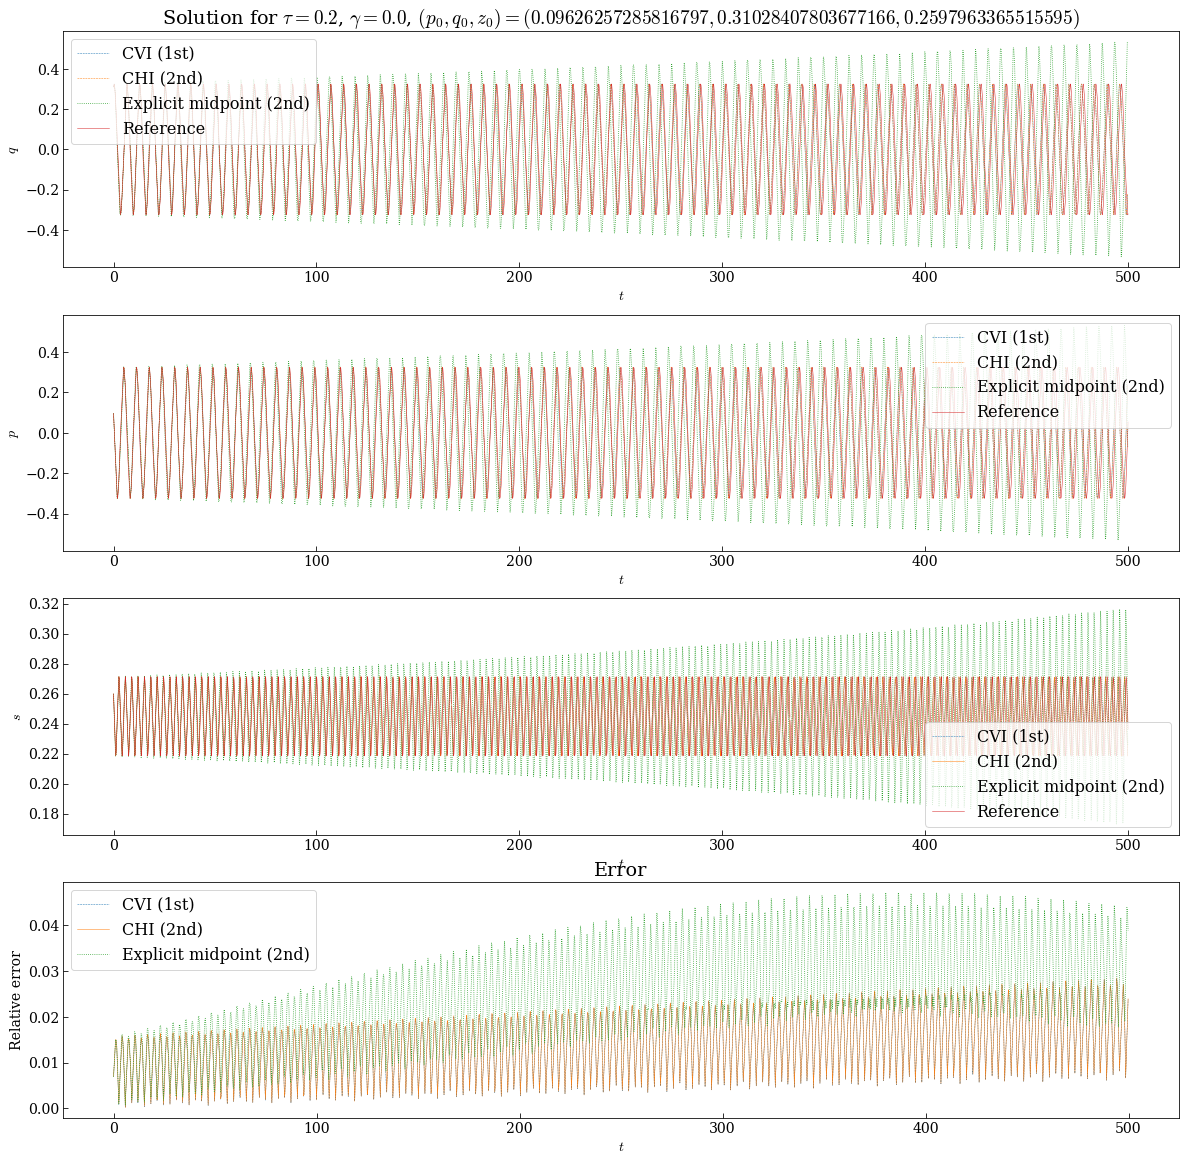

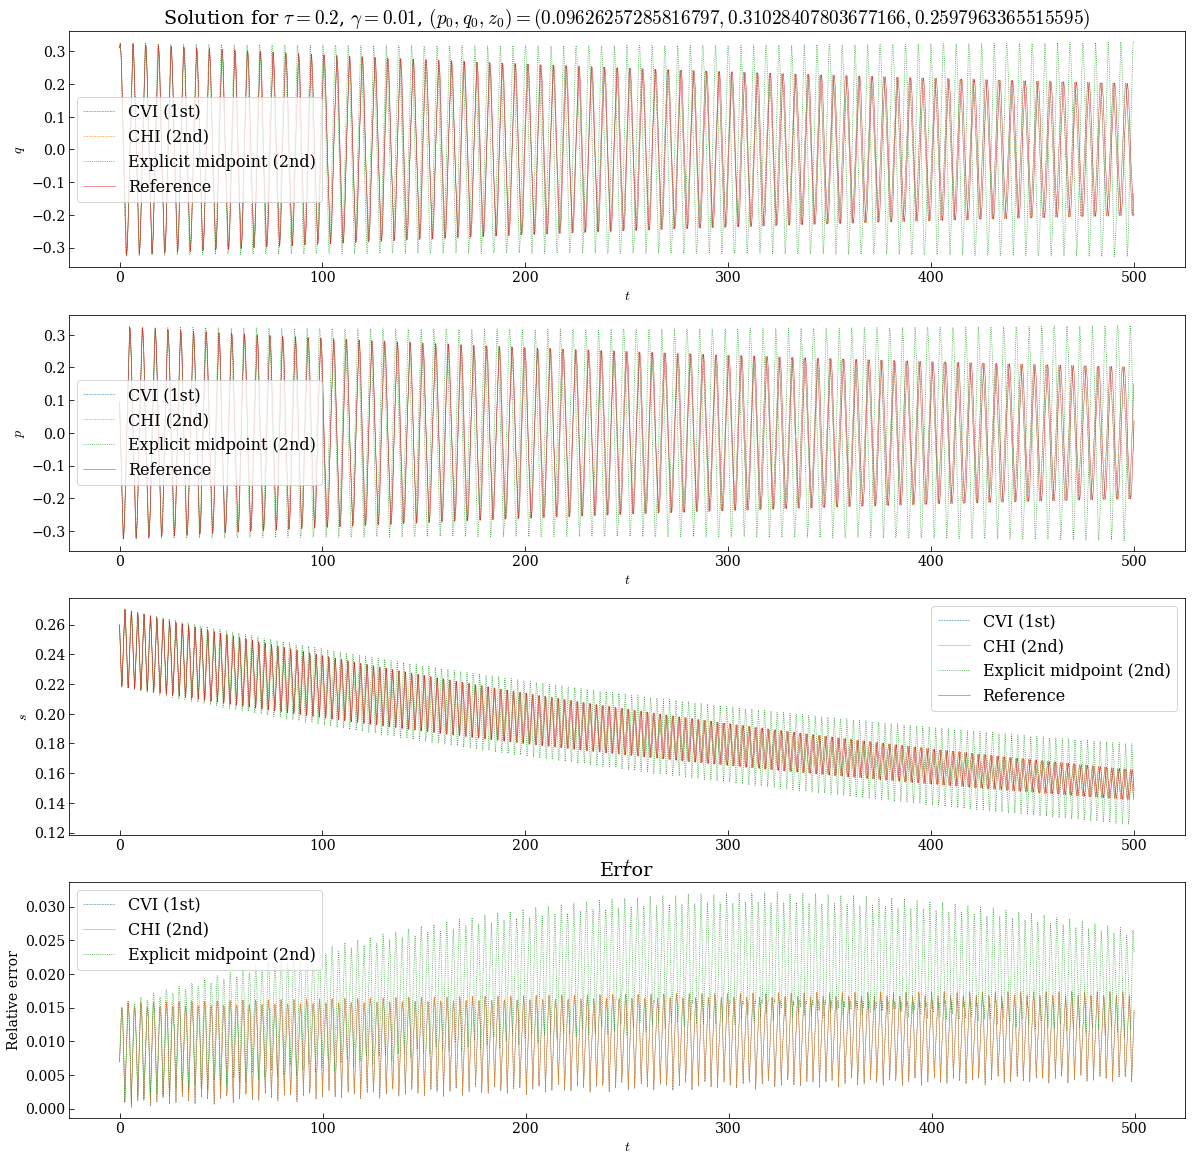

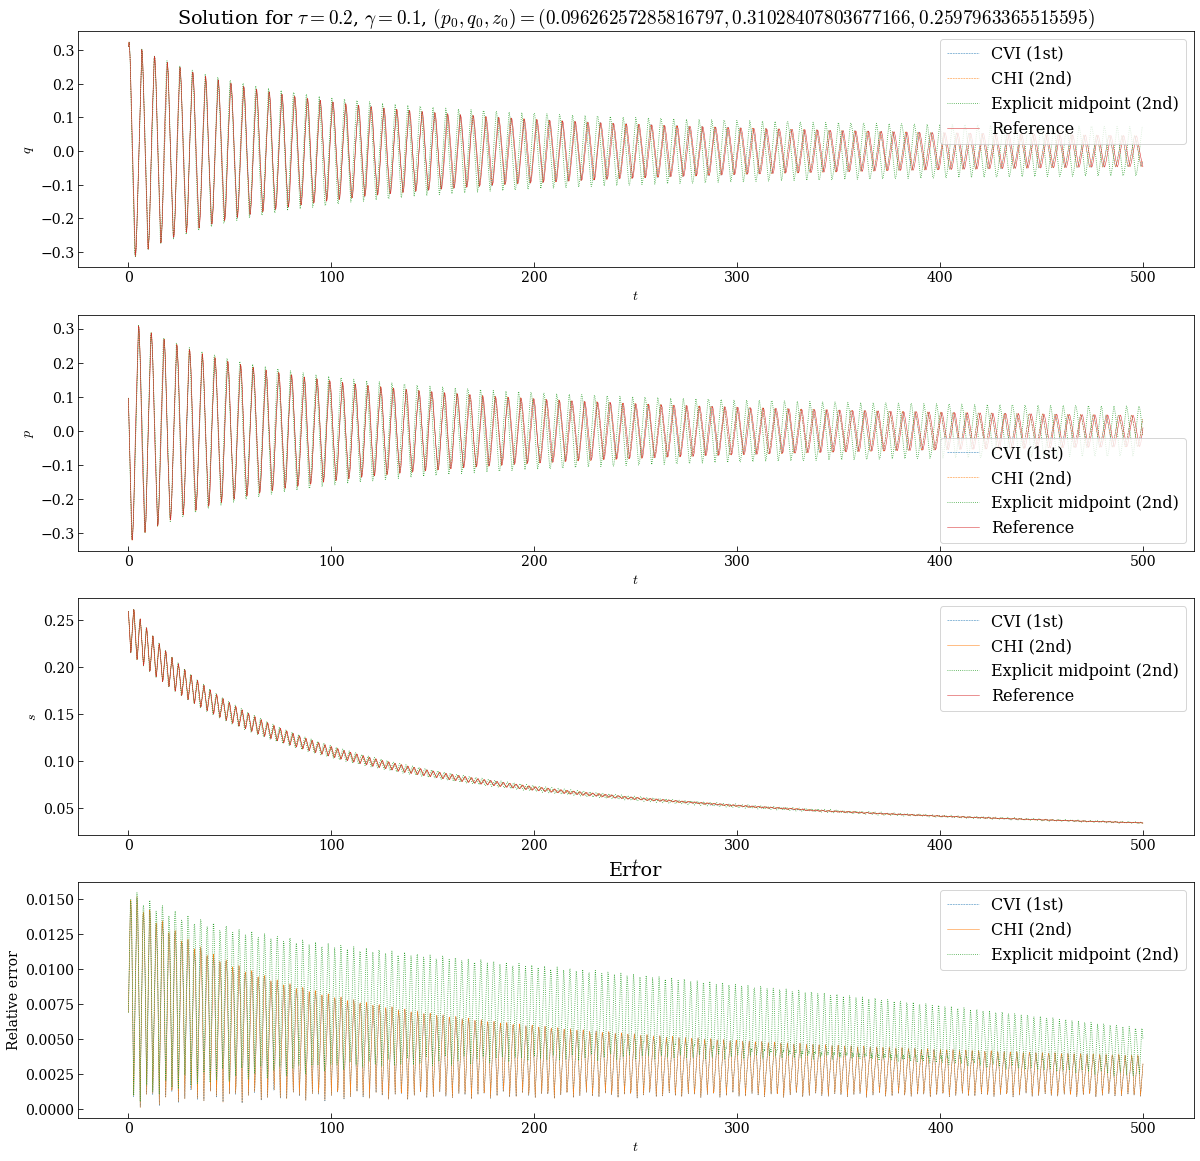

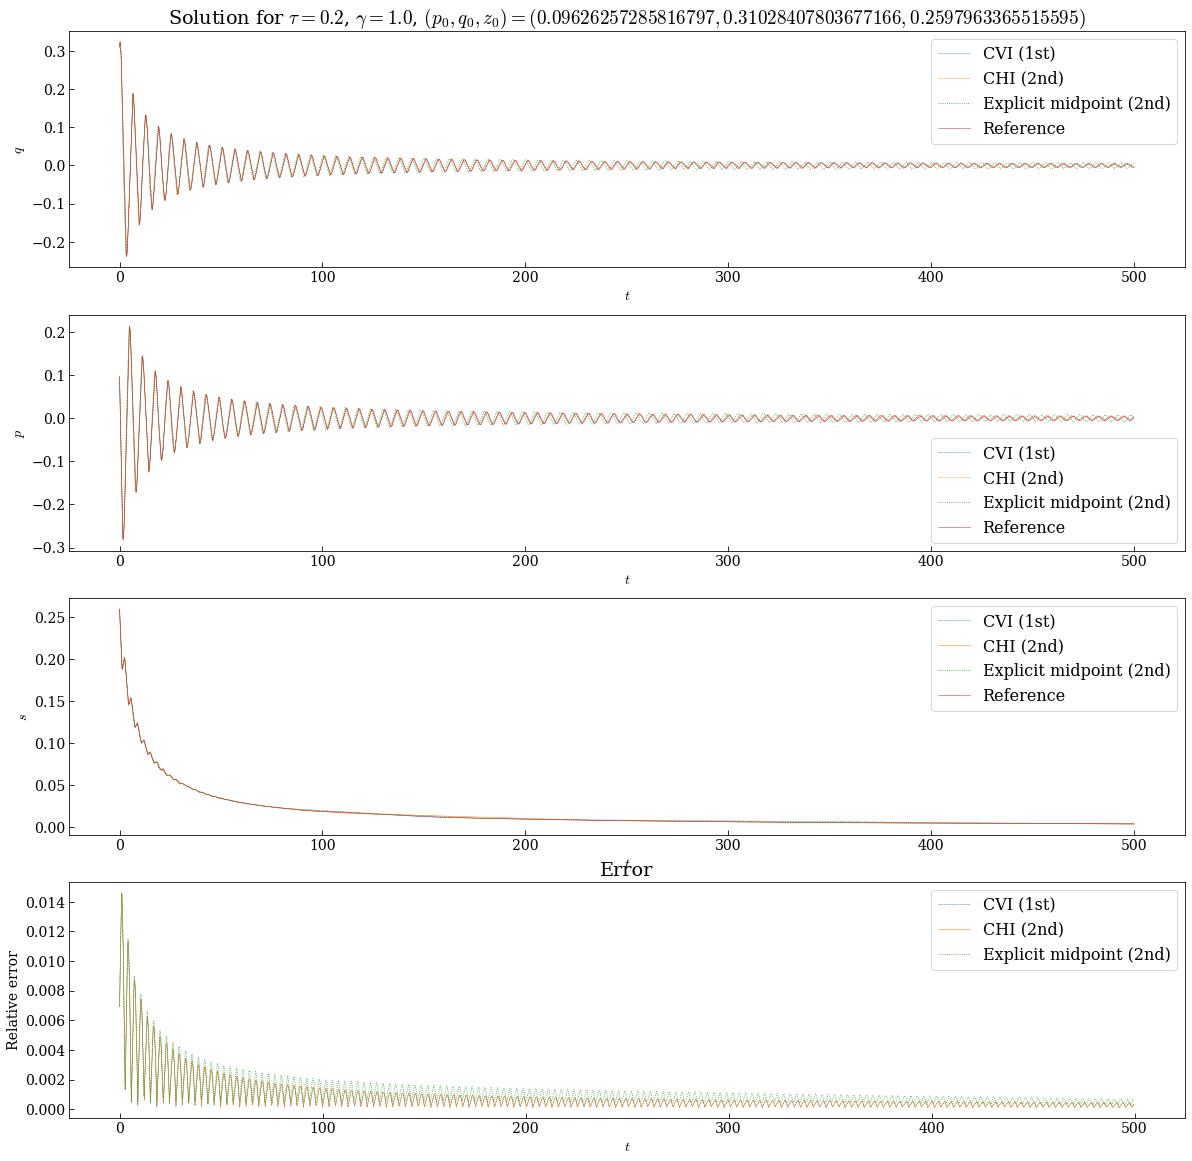

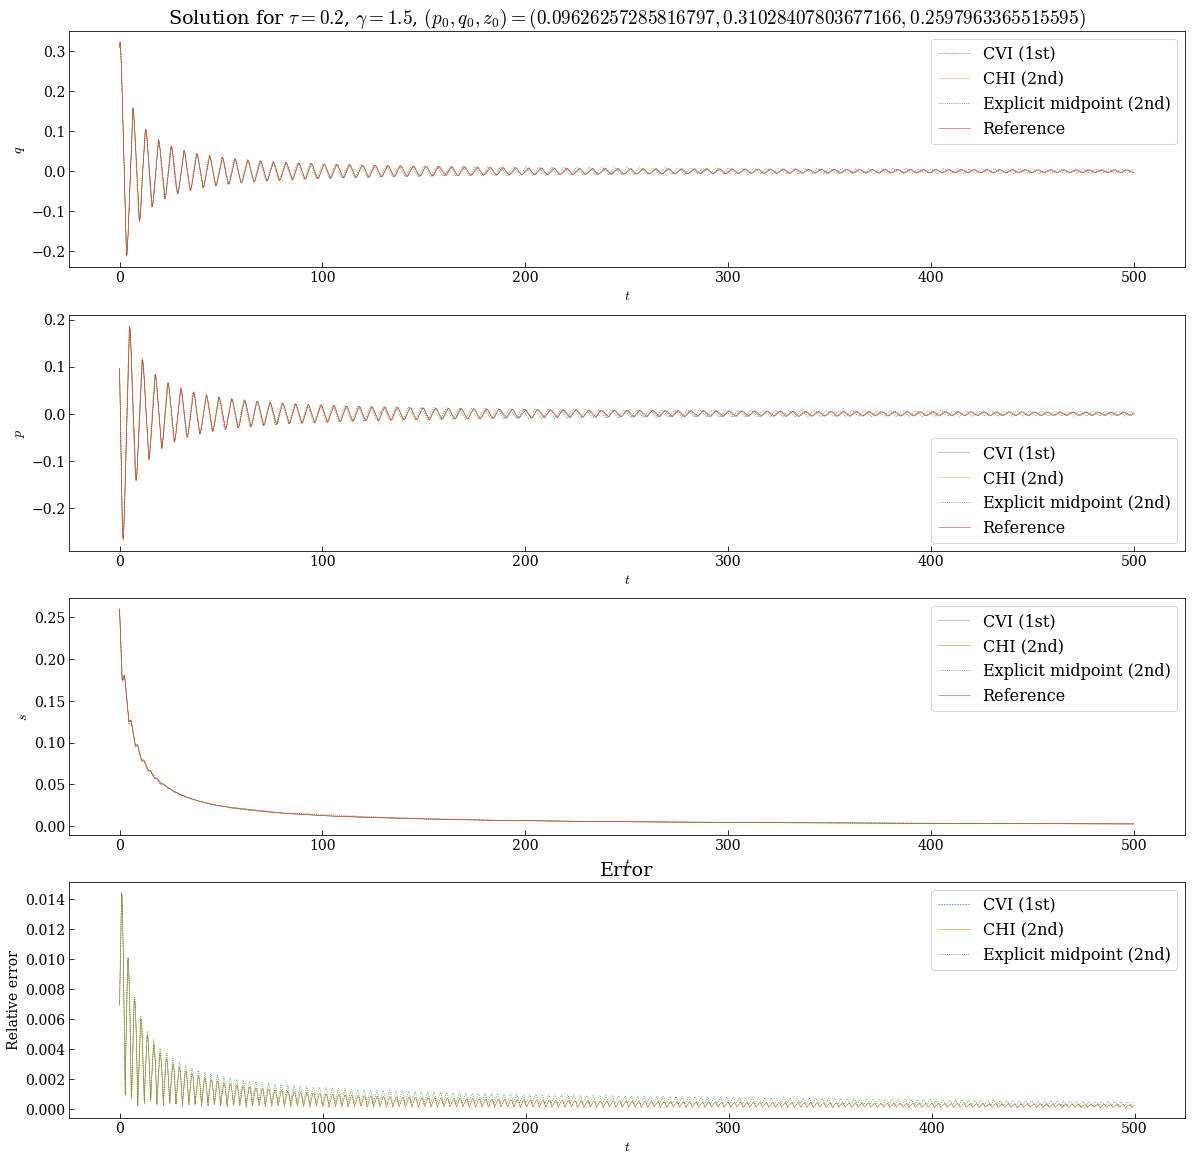

In [11]:
init = 0.5 * np.random.rand(3)
# init = (.5, -.7, .2)
tspan = (0.0, 500.0)
delta = 10

for a in [0.0, 0.01, 0.1, 1.0, 1.5]:
    for h in [0.2]:
        cmp_plot(init, tspan, a, h, delta)

# Variational simulations around $H^{-1}(0)$ surface

In [12]:
t0, tf = (0.0, 50.0)
h = 0.1
a = 1.0
C = 18
ts = np.arange(t0, tf, h)

<ipython-input-13-724fef1446e7>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")
<ipython-input-3-021e82af3b9d>:16: RuntimeWarning: overflow encountered in double_scalars
  return 0.5 * self.f(t) * z ** 2
/Users/mseri/code/gsi2021/integrators/contact.py:104: RuntimeWarning: invalid value encountered in double_scalars
  x + (dt - 0.5 * dt ** 2 * system.Fz(z, t)) * p - 0.5 * dt ** 2 * system.Vq(x, t)
/Users/mseri/code/gsi2021/integrators/contact.py:112: RuntimeWarning: invalid value encountered in double_scalars
  (1.0 - 0.5 * dt * system.Fz(z, t)) * p
/opt/local/Library/Frameworks/Python.framework/Versions/3.9/lib/pyth

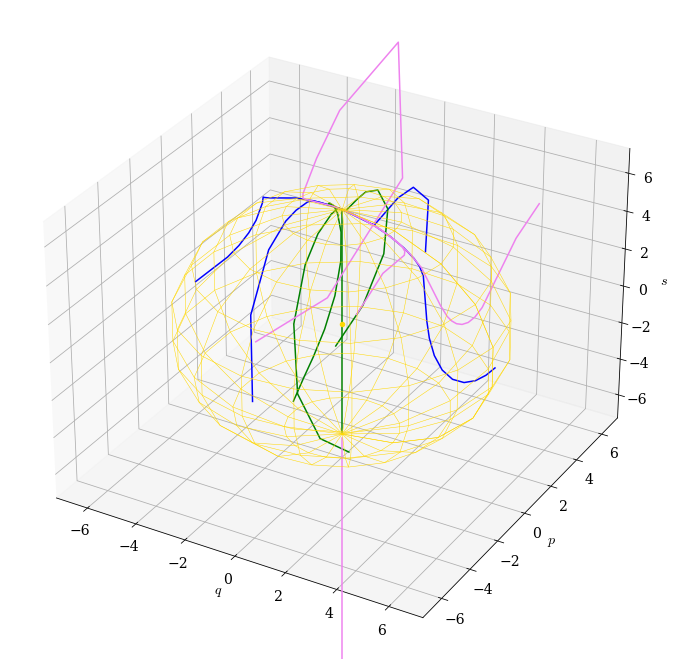

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection="3d")

for init in [
    # (2, -3, -2), (2, 0, -2), (-2, 1, -3)
    (0, 0, 6),
    (0, 0, -6),
    (6, 0, 0),
    (0, 6, 0),
    (-6, 0, 0),
    (0, -6, 0),
    (0, 0, -5.9),
    (0, -2, -5),
    (3, -2, -4),
    (-3, 2, -4),
    (5, 5, 5),
    (4, -6, -6),
    (-6, 4, 6),
    (0, 0, -6.2),
]:
    sol, sols, _ = quadratic_v(init, ts, a, C=C)
    x, y, z = init
    n = x ** 2 + y ** 2 + z ** 2
    if n == 36:
        color = "blue"
    elif n < 36:
        color = "green"
    else:
        color = "violet"
    ax.plot(
        sol[:, 1],
        sol[:, 0],
        sols,
        label="({},{},{})".format(*init),
        color=color,
        linewidth=1.5,
    )

u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
x = np.sqrt(2.0 * C) * np.cos(u) * np.sin(v)
y = np.sqrt(2.0 * C) * np.sin(u) * np.sin(v)
z = np.sqrt(2.0 * C) * np.cos(v)
ax.plot_wireframe(x, y, z, color="gold", linewidth=0.5)

ax.scatter([0], [0], [0], color="gold")

ax.set_xlabel("$q$")
ax.set_ylabel("$p$")
ax.set_zlabel("$s$")
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.set_zlim(-7, 7)

# plt.legend()
plt.savefig("images/spherevar.pdf", transparent=True, bbox_inches="tight")
plt.show()

# Hamiltonian simulations around $H^{-1}(0)$ surface

/Users/mseri/code/gsi2021/integrators/contact.py:157: UserWarning: The integration reached a singularity. Time step: $0.1$ , singulrity in $0.05707257874989828$
  warnings.warn(
/Users/mseri/code/gsi2021/integrators/contact.py:142: RuntimeWarning: invalid value encountered in double_scalars
  s += dt * np.linalg.norm(p) ** 2 / 2.0
/Users/mseri/code/gsi2021/integrators/contact.py:147: RuntimeWarning: invalid value encountered in double_scalars
  p += -dt * system.Vq(q, t)


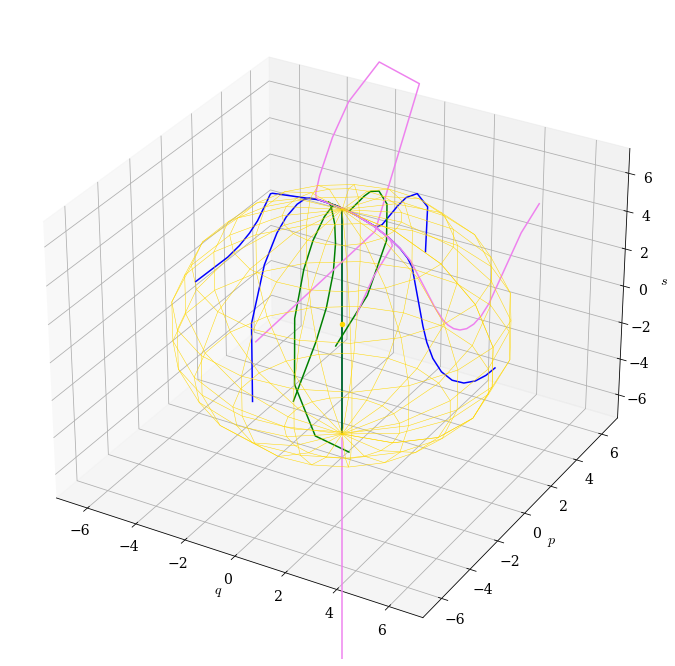

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection="3d")

for init in [
    # (2, -3, -2), (2, 0, -2), (-2, 1, -3)
    (0, 0, 6),
    (0, 0, -6),
    (6, 0, 0),
    (0, 6, 0),
    (-6, 0, 0),
    (0, -6, 0),
    (0, 0, -5.9),
    (0, -2, -5),
    (3, -2, -4),
    (-3, 2, -4),
    (5, 5, 5),
    (4, -6, -6),
    (-6, 4, 6),
    (0, 0, -6.2),
]:
    sol, sols, _ = quadratic_h(init, ts, a, C=C)
    x, y, z = init
    n = x ** 2 + y ** 2 + z ** 2
    if n == 36:
        color = "blue"
    elif n < 36:
        color = "green"
    else:
        color = "violet"
    ax.plot(
        sol[:, 1],
        sol[:, 0],
        sols,
        label="({},{},{})".format(*init),
        color=color,
        linewidth=1.5,
    )

u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
x = np.sqrt(2.0 * C) * np.cos(u) * np.sin(v)
y = np.sqrt(2.0 * C) * np.sin(u) * np.sin(v)
z = np.sqrt(2.0 * C) * np.cos(v)
ax.plot_wireframe(x, y, z, color="gold", linewidth=0.5)

ax.scatter([0], [0], [0], color="gold")

ax.set_xlabel("$q$")
ax.set_ylabel("$p$")
ax.set_zlabel("$s$")
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.set_zlim(-7, 7)

# plt.legend()
plt.savefig("images/sphereham.pdf", transparent=True, bbox_inches="tight")
plt.show()

# Comparisons around a stiff initial condition

Runge--Kutta 4, the 2nd order contact variational integrator and the 2nd order contact Hamiltonian integrator are compared for initial conditions outside the sphere and close to the unstable fixed point on the south pole.

<ipython-input-5-b418f524438b>:1: RuntimeWarning: overflow encountered in double_scalars
  osc = lambda p, x, z, t, γ: -x - γ * p * z
<ipython-input-5-b418f524438b>:5: RuntimeWarning: overflow encountered in double_scalars
  lag = lambda p, q, z: p ** 2 / 2.0 - q ** 2 / 2.0 + C - γ * z ** 2 / 2.0
<ipython-input-5-b418f524438b>:5: RuntimeWarning: invalid value encountered in double_scalars
  lag = lambda p, q, z: p ** 2 / 2.0 - q ** 2 / 2.0 + C - γ * z ** 2 / 2.0
<ipython-input-5-b418f524438b>:1: RuntimeWarning: overflow encountered in double_scalars
  osc = lambda p, x, z, t, γ: -x - γ * p * z
<ipython-input-5-b418f524438b>:5: RuntimeWarning: overflow encountered in double_scalars
  lag = lambda p, q, z: p ** 2 / 2.0 - q ** 2 / 2.0 + C - γ * z ** 2 / 2.0
<ipython-input-5-b418f524438b>:5: RuntimeWarning: invalid value encountered in double_scalars
  lag = lambda p, q, z: p ** 2 / 2.0 - q ** 2 / 2.0 + C - γ * z ** 2 / 2.0


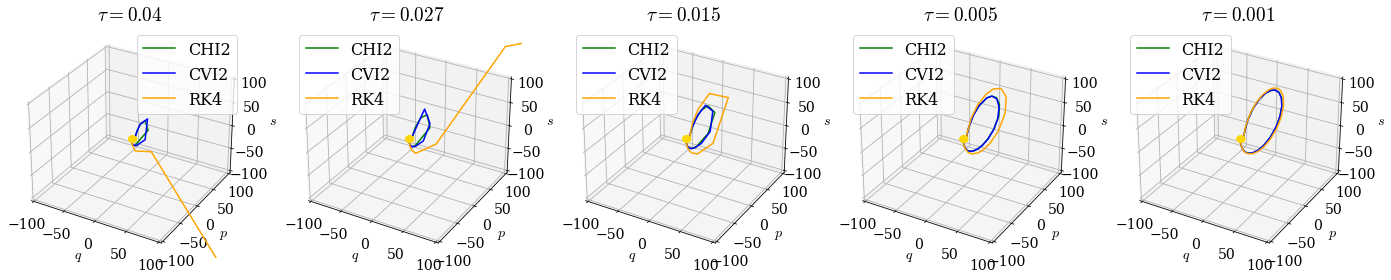

(q,p,s)=(0,-1,-7)


In [15]:
init = (0, -1, -7)
fig = plt.figure(figsize=(24, 6))

for i, dt in enumerate([0.04, 0.027, 0.015, 0.005, 0.001]):
    ax = fig.add_subplot(1, 5, i + 1, projection="3d")

    tsl = np.arange(t0, tf / 10, dt)
    solh, solsh, _ = quadratic_h(init, tsl, a, C=C)
    ax.plot(solh[:, 1], solh[:, 0], solsh, label="CHI2", color="green")
    sol, sols, _ = quadratic_v(init, tsl, a, C=C)
    ax.plot(sol[:, 1], sol[:, 0], sols, label="CVI2", color="blue")
    solm = rk4s(init, tsl, a, h, acc=osc, C=C)
    ax.plot(solm[:, 1], solm[:, 0], solm[:, 2], label="RK4", color="orange")

    u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
    x = np.sqrt(2.0 * C) * np.cos(u) * np.sin(v)
    y = np.sqrt(2.0 * C) * np.sin(u) * np.sin(v)
    z = np.sqrt(2.0 * C) * np.cos(v)
    ax.plot_wireframe(x, y, z, color="gold", linewidth=0.5)

    ax.scatter([0], [0], [0], color="gold")

    ax.set_xlabel("$q$")
    ax.set_ylabel("$p$")
    ax.set_zlabel("$s$")
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_zlim(-100, 100)
    ax.set_title("$\\tau={}$".format(dt))

    plt.legend()

plt.savefig(
    "images/sph-{}_{}_{}.pdf".format(*init), transparent=True, bbox_inches="tight"
)
plt.show()
print("(q,p,s)=({},{},{})".format(*init))

# Study equilibria for Hamiltonian Integrator

The equilibria of the quadratic Hamiltonian are given by:
$$ x_{1,2} = \left( 0, 0, \pm \sqrt{2 C \gamma^{-1}}\right),$$
while the equilibria of the stepper are given by:
$$ x_{1,2} = \left( 0, 0, \pm \frac12 \sqrt{8 C \gamma^{-1} + \tau^2 C^2}\right).$$

In the simulations that follow we compare the position of the numerical stable fixed point $N$ on the north pole of the sphere and its approximate position obtained via the modified Hamiltonian for different values of the step.

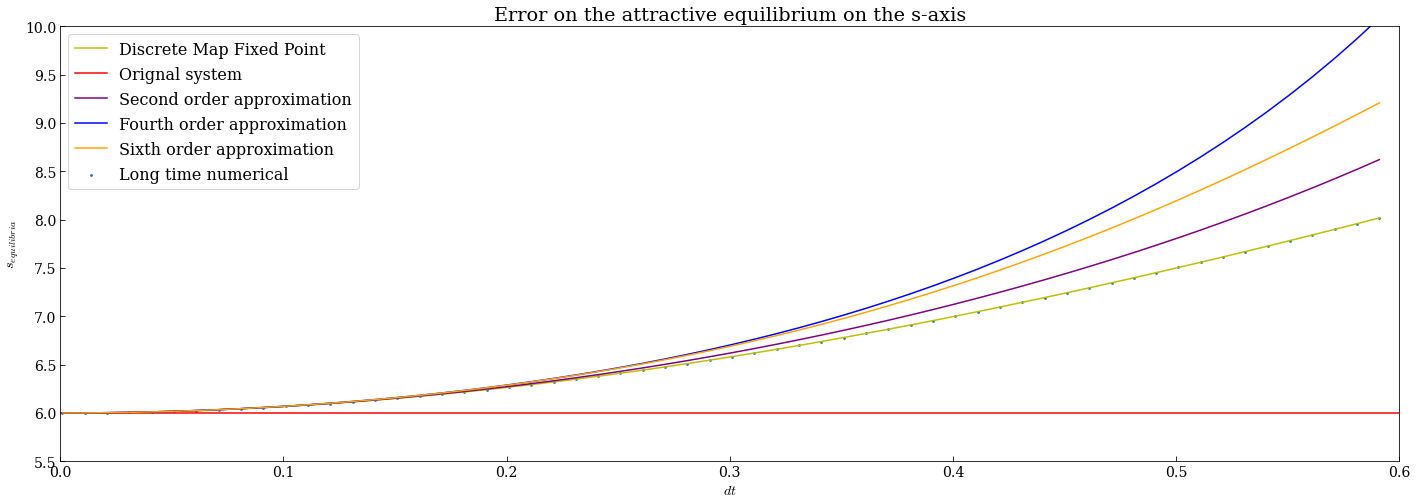

In [15]:
fig = plt.figure(figsize=(24, 8))
dtf = 0.6
dtspan = np.arange(0.001, dtf, 0.01)
ndt = len(dtspan)
seqn = np.empty(ndt, dtype=np.float64)
seqndis = np.empty(ndt, dtype=np.float64)
seqnsec = np.empty(ndt, dtype=np.float64)
seqnfor = np.empty(ndt, dtype=np.float64)
seqnsix = np.empty(ndt, dtype=np.float64)
init = [0.1, 0.1, 7.0]
C = 18
a = 1


def eqnex(C, γ):
    return np.sqrt(2 * C / γ)


def eqndis(C, γ, dt):
    return np.sqrt(8 * C + γ * (dt * C) ** 2) / (2 * np.sqrt(γ))


eqndis1 = lambda dt: eqndis(C, a, dt)

for i, dt in enumerate(dtspan):
    XH2 = lambda x: XHquadsecond(x, C, a, dt)
    XH4 = lambda x: XHquadforth(x, C, a, dt)
    XH6 = lambda x: XHquadsixth(x, C, a, dt)
    tspan = np.arange(0.0, 1000, dt)
    solh, solsh, _ = quadratic_h(init, tspan, a, C=C)
    seqn[i] = solsh[-1]
    seqndis[i] = eqndis1(dt)
    seqnsec[i] = so.fsolve(XH2, [0, 0, eqnex(C, a)])[2]
    seqnfor[i] = so.fsolve(XH4, [0, 0, eqnex(C, a)])[2]
    seqnsix[i] = so.fsolve(XH6, [0, 0, eqnex(C, a)])[2]
    print("Step : ", i + 1, "/", ndt + 1, end="\r")

plt.title("Error on the attractive equilibrium $N$ on the s-axis")
plt.scatter(dtspan, seqn, s=3, label="Long time numerical")
plt.plot(dtspan, seqndis, color="y", label="Discrete Map Fixed Point")
plt.axhline(y=eqnex(C, a), color="r", linestyle="-", label="Orignal system")
plt.plot(dtspan, seqnsec, color="purple", label="Second order approximation")
plt.plot(dtspan, seqnfor, color="blue", label="Fourth order approximation")
plt.plot(dtspan, seqnsix, color="orange", label="Sixth order approximation")

plt.xlim(0.0, dtf)
plt.ylim(5.5, 10)
plt.xlabel("$\tau$")
plt.ylabel("$N_s$")
plt.legend()
plt.savefig("images/attequiposition.pdf", transparent=True, bbox_inches="tight")
plt.show()

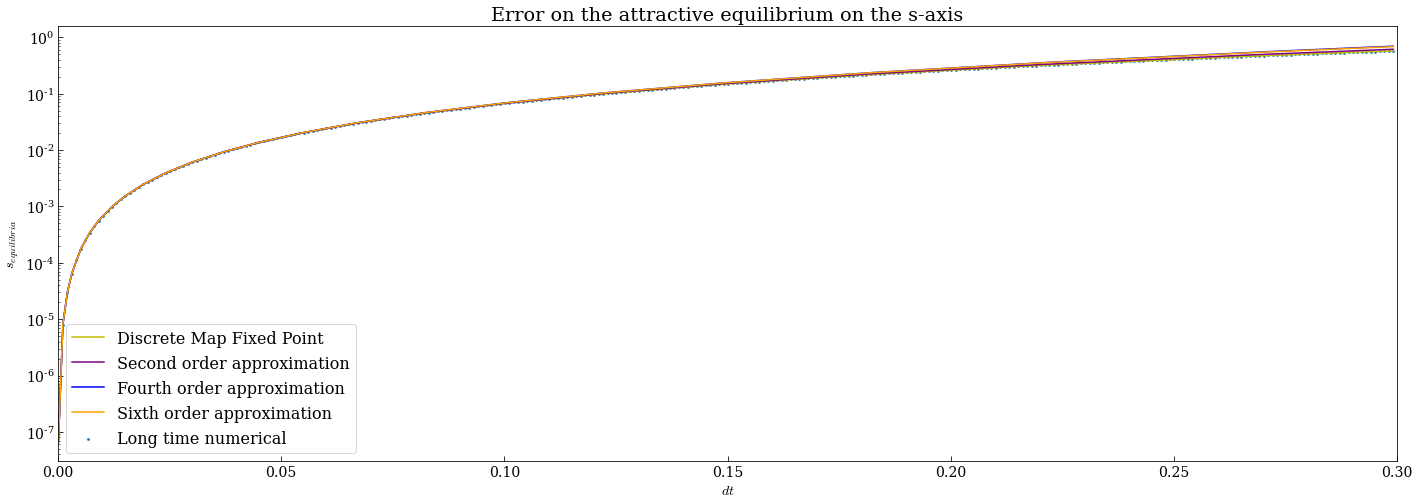

In [19]:
fig = plt.figure(figsize=(24, 8))
dtf = 0.3
dtspan = np.arange(0.0001, dtf, 0.001)
ndt = len(dtspan)
seqn = np.empty(ndt, dtype=np.float64)
seqndis = np.empty(ndt, dtype=np.float64)
seqnsec = np.empty(ndt, dtype=np.float64)
seqnfor = np.empty(ndt, dtype=np.float64)
seqnsix = np.empty(ndt, dtype=np.float64)
init = [0.1, 0.1, 7.0]
C = 18
a = 1


def eqnex(C, γ):
    return np.sqrt(2 * C / γ)


def eqndis(C, γ, dt):
    return np.sqrt(8 * C + γ * (dt * C) ** 2) / (2 * np.sqrt(γ))


eqndis1 = lambda dt: eqndis(C, a, dt)

for i, dt in enumerate(dtspan):
    XH2 = lambda x: XHquadsecond(x, C, a, dt)
    XH4 = lambda x: XHquadforth(x, C, a, dt)
    XH6 = lambda x: XHquadsixth(x, C, a, dt)
    tspan = np.arange(0.0, 25, dt)
    solh, solsh, _ = quadratic_h(init, tspan, a, C=C)
    seqn[i] = solsh[-1]
    seqndis[i] = eqndis1(dt)
    seqnsec[i] = so.fsolve(XH2, [0, 0, eqnex(C, a)])[2]
    seqnfor[i] = so.fsolve(XH4, [0, 0, eqnex(C, a)])[2]
    seqnsix[i] = so.fsolve(XH6, [0, 0, eqnex(C, a)])[2]
    print("Step : ", i + 1, "/", ndt + 1, end="\r")

plt.title("Error on the attractive equilibrium $N$ on the s-axis")
plt.scatter(dtspan, abs(seqn - eqnex(C, a)), s=3, label="Long time numerical")
plt.plot(
    dtspan, abs(seqndis - eqnex(C, a)), color="y", label="Discrete Map Fixed Point"
)
# plt.axhline(y = eqnex(C,a), color = 'r', linestyle = '-', label = "Orignal system")
plt.plot(
    dtspan,
    abs(seqnsec - eqnex(C, a)),
    color="purple",
    label="Second order approximation",
)
plt.plot(
    dtspan, abs(seqnfor - eqnex(C, a)), color="blue", label="Fourth order approximation"
)
plt.plot(
    dtspan,
    abs(seqnsix - eqnex(C, a)),
    color="orange",
    label="Sixth order approximation",
)

plt.xlim(0.0, dtf)
# plt.ylim(5.5,10)
plt.yscale("log")
plt.xlabel("$\tau$")
plt.ylabel("$N_s$")
plt.legend()
plt.show()

In [49]:
# init = (.5, -.7, -.2)
init = 0.5 * np.random.rand(3)
tspan = (0.0, 500.0)
a = 0.1
h=0.1
times(init, tspan, a, h,rep=10)

           Time of Executions in seconds 
dt =  0.1
----------------------------------------------------
Contact Hamiltonian splitting:   0.09861687326431275 +/- 0.008311038844895494
Contact variational:             0.07238773655891419 +/- 0.005263718427399425
Runge-Kutta-4:                   0.1375115120410919 +/- 0.007522333934035659
Midpoint:                        0.036374335050582886 +/- 0.0030629444675006456
Leapfrog (symplectic adapted)    0.34824194574356077 +/- 0.023220046627599238
